Data from Kaggle: https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset/data

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import string
from collections import Counter, defaultdict
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams
import nltk
nltk.download('punkt')
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import transformers
from tokenizers import BertWordPieceTokenizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import tensorflow.keras as keras

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))

sns.set()
custom_palette = {'positive': 'mediumseagreen', 'negative': 'indianred'}

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wojwo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wojwo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Goals

1. Find key aspects that make a restaurant good or bad
2. Predict review rating
3. Expand knowledge about NLP techniques, neural networks and model metrics

## Data Overview

In [6]:
data_raw = pd.read_csv('restaurant_reviews.csv')

In [7]:
data_raw.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


In [8]:
data_raw.isnull().sum()

Restaurant       0
Reviewer        38
Review          45
Rating          38
Metadata        38
Time            38
Pictures         0
7514          9999
dtype: int64

In [9]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Restaurant  10000 non-null  object 
 1   Reviewer    9962 non-null   object 
 2   Review      9955 non-null   object 
 3   Rating      9962 non-null   object 
 4   Metadata    9962 non-null   object 
 5   Time        9962 non-null   object 
 6   Pictures    10000 non-null  int64  
 7   7514        1 non-null      float64
dtypes: float64(1), int64(1), object(6)
memory usage: 625.1+ KB


In [10]:
mask = data_raw['7514'].notnull()
data_raw[mask]

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0


## Clean Data

In [11]:
data = data_raw.copy()

In [12]:
to_drop = data[data['Rating'] == 'Like'].index
data.drop(to_drop, inplace=True)
data['Rating'] = data['Rating'].astype(float)

In [13]:
data['Time'] = pd.to_datetime(data['Time'], format='%m/%d/%Y %H:%M')

In [14]:
data.drop(['7514'], axis=1, inplace=True)

In [15]:
data.dropna(subset=['Rating', 'Review'], inplace=True)

In [16]:
data.columns = data.columns.str.lower()

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9954 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   restaurant  9954 non-null   object        
 1   reviewer    9954 non-null   object        
 2   review      9954 non-null   object        
 3   rating      9954 non-null   float64       
 4   metadata    9954 non-null   object        
 5   time        9954 non-null   datetime64[ns]
 6   pictures    9954 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 622.1+ KB


## EDA

In [18]:
def show_category_countplot(data_ref, x, hue = None):
    if x == hue:
        return
    
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))  
    
    if hue:
        sns.countplot(data=data_ref, x=x, hue=hue, ax=ax1, palette=custom_palette)
        ax1.set_title(f'Countplot of {x} and {hue}')
    else:
        sns.countplot(data=data_ref, x=x, ax=ax1, color='lightseagreen')
        ax1.set_title(f'Countplot of {x}')
    
    for p in ax1.patches:
        height = p.get_height()
        if height > 0:
            xy = (p.get_x() + p.get_width() / 2., height)
            ax1.annotate(f'{height}', xy, ha='center', va='bottom', color='gray')
    
    plt.tight_layout()
    plt.show()

In [19]:
def print_category_percentages(data_ref, x):
    category_counts = data_ref[x].value_counts(normalize=True) * 100
    formatted_category_counts = category_counts.map('{:.2f}%'.format)
    print(formatted_category_counts)

### Rating

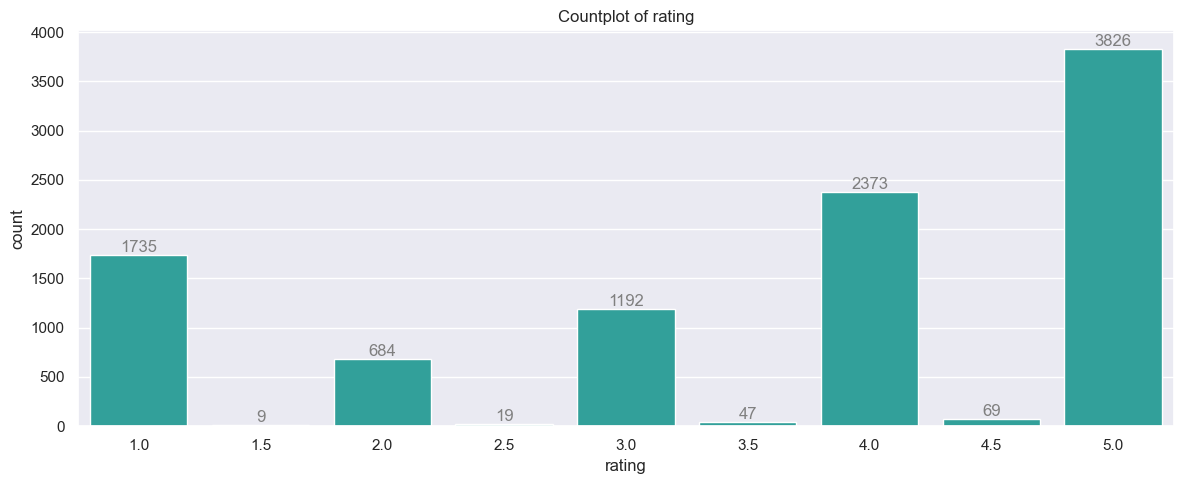

In [20]:
show_category_countplot(data, 'rating')

In [21]:
print_category_percentages(data, 'rating')

5.0    38.44%
4.0    23.84%
1.0    17.43%
3.0    11.98%
2.0     6.87%
4.5     0.69%
3.5     0.47%
2.5     0.19%
1.5     0.09%
Name: rating, dtype: object


### Label

In [22]:
def create_label(rating):
    if rating >= 3.0:
        return 'positive'
    if rating <= 2.5:
        return 'negative'
    return 'neutral'

In [23]:
data['label'] = data['rating'].apply(create_label)

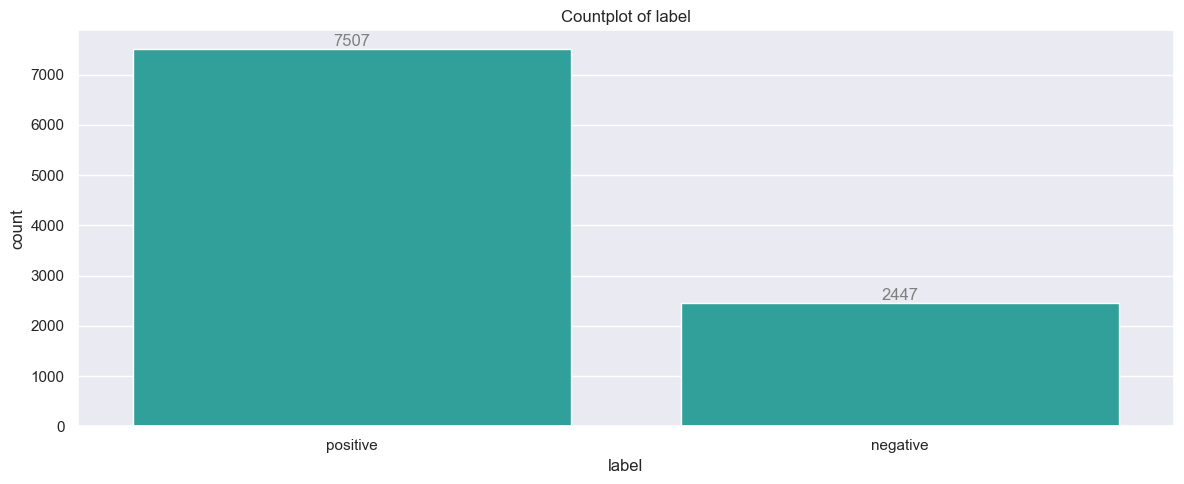

In [24]:
show_category_countplot(data, 'label')

In [25]:
print_category_percentages(data, 'label')

positive    75.42%
negative    24.58%
Name: label, dtype: object


### Time
Date when review was publicated. 

In [26]:
data['date'] = data['time'].dt.date

In [27]:
date_count = data['date'].value_counts().sort_index()
date_count_df = pd.DataFrame(date_count).reset_index()
date_count_df.columns = ['date', 'count']

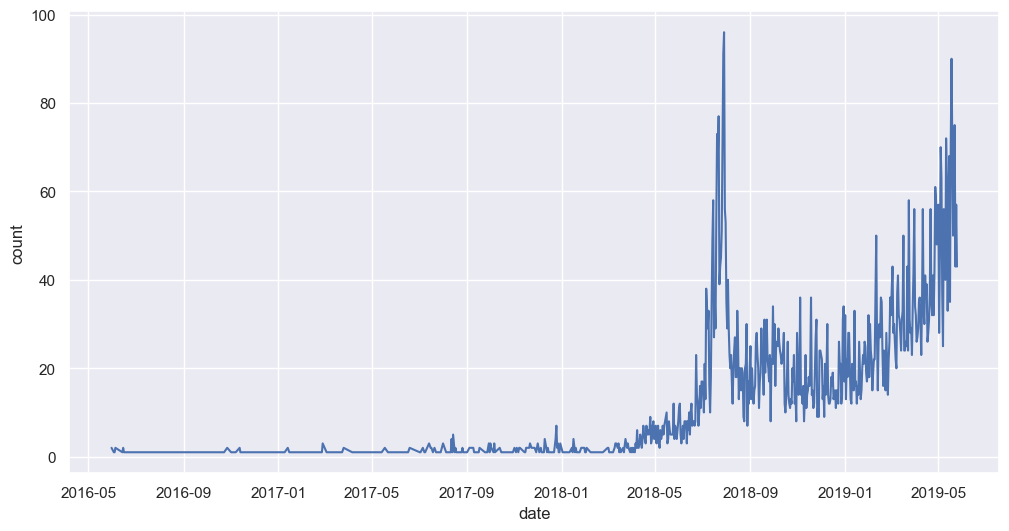

In [28]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='count', data=date_count_df)
plt.show()

There are peaks in the summer season. 

### Letter Count

A number of letter for each review.

In [29]:
def count_letters(text):
    return len(text.replace(" ", ""))

In [30]:
data['review_letter_count'] = data['review'].apply(count_letters)

In [31]:
def show_numerical_box_plot(data_ref, x, y):       
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))    
    sns.boxplot(data=data_ref, x=x, y=y, width=0.5, palette=custom_palette)
    ax1.set_title(f'Boxplot of {x} and {y}')
    
    plt.tight_layout()
    plt.show()

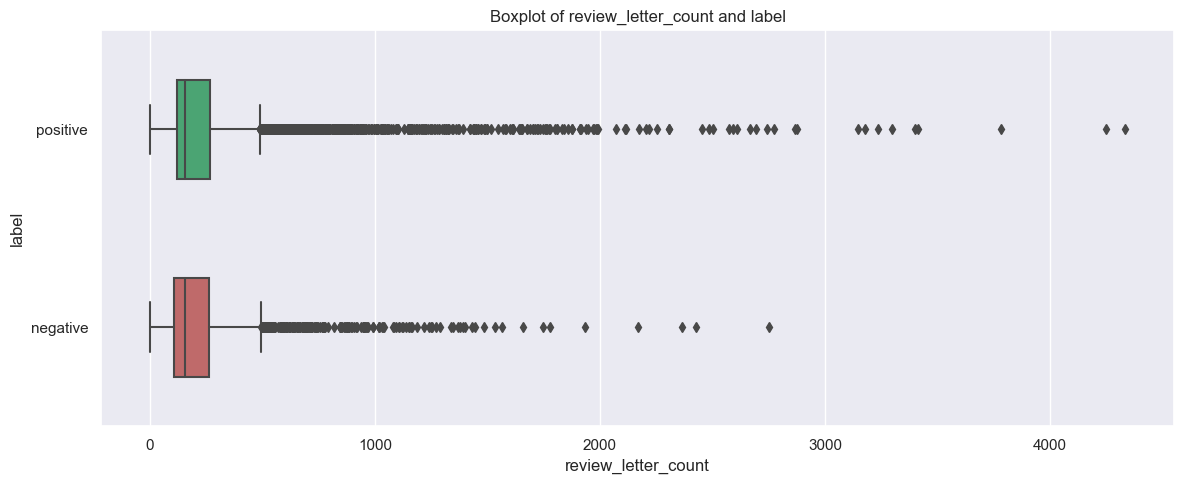

In [32]:
show_numerical_box_plot(data, 'review_letter_count', 'label')

In [33]:
def show_histplot(data, x, hue, xmin=None, xmax=None):
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))    
    sns.histplot(data=data, x=x, hue=hue, bins=1000, multiple='stack', palette=custom_palette)
    ax1.set_title(f'Histplot of {x} and {hue}')
    
    if xmin is not None and xmax is not None:
        ax1.set_xlim(xmin, xmax)   
    
    plt.tight_layout()
    plt.show()

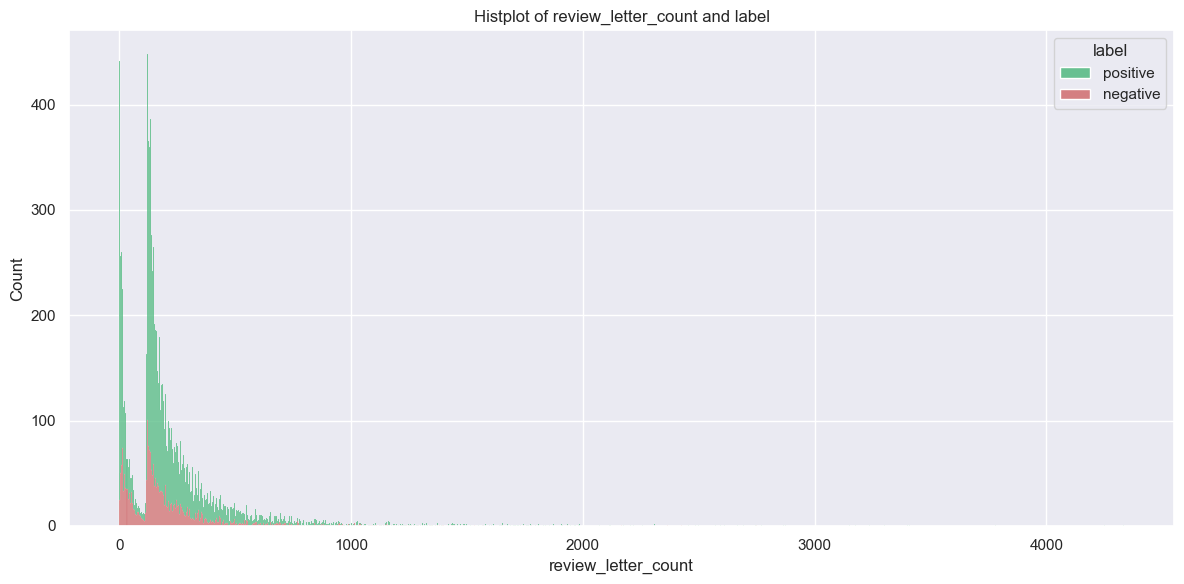

In [34]:
show_histplot(data, 'review_letter_count', 'label')

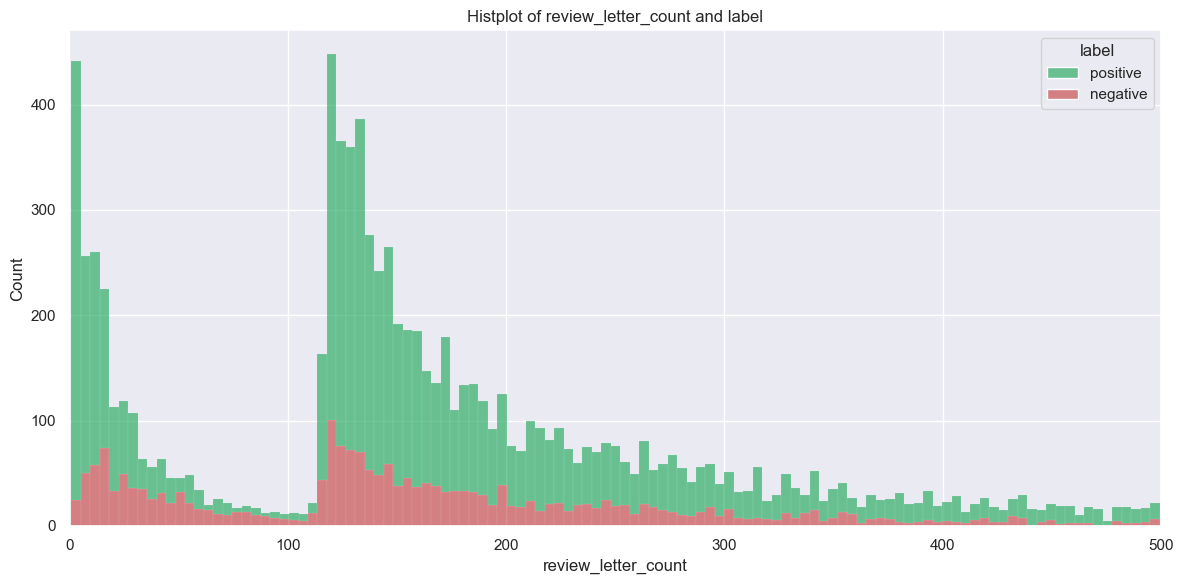

In [35]:
show_histplot(data, 'review_letter_count', 'label', 0, 500)

- There is an interesting sudden rise after number of 100.  
- A lot of outliers. 

### Word Count

A number of words for each review.

In [36]:
def count_words(text):
    return len(text.split(" "))

In [37]:
data['review_words_count'] = data['review'].apply(count_words)

In [38]:
data['review_words_count'].describe()

count    9954.000000
mean       49.050532
std        59.103939
min         1.000000
25%        24.000000
50%        34.000000
75%        57.000000
max       964.000000
Name: review_words_count, dtype: float64

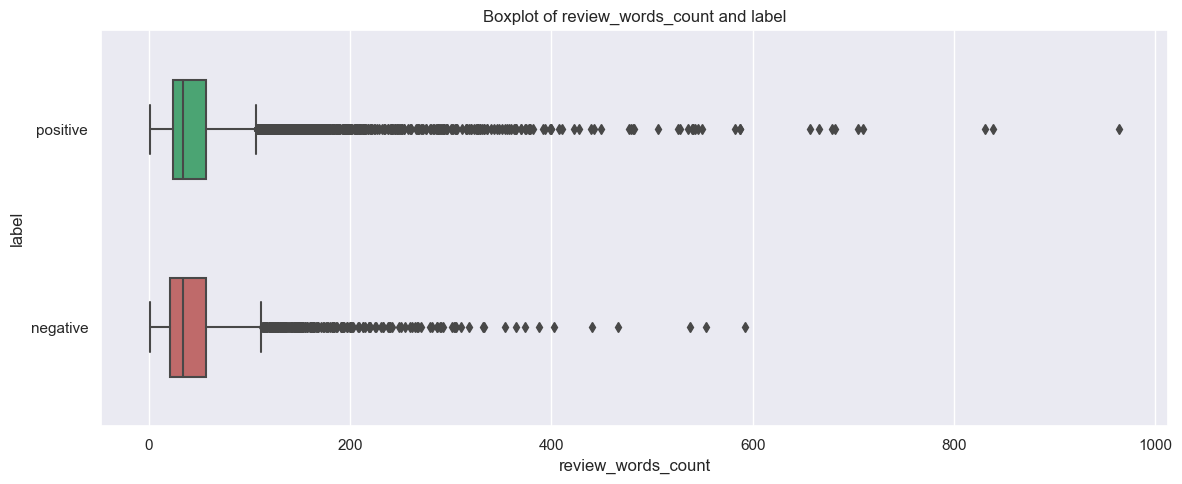

In [39]:
show_numerical_box_plot(data, 'review_words_count', 'label')

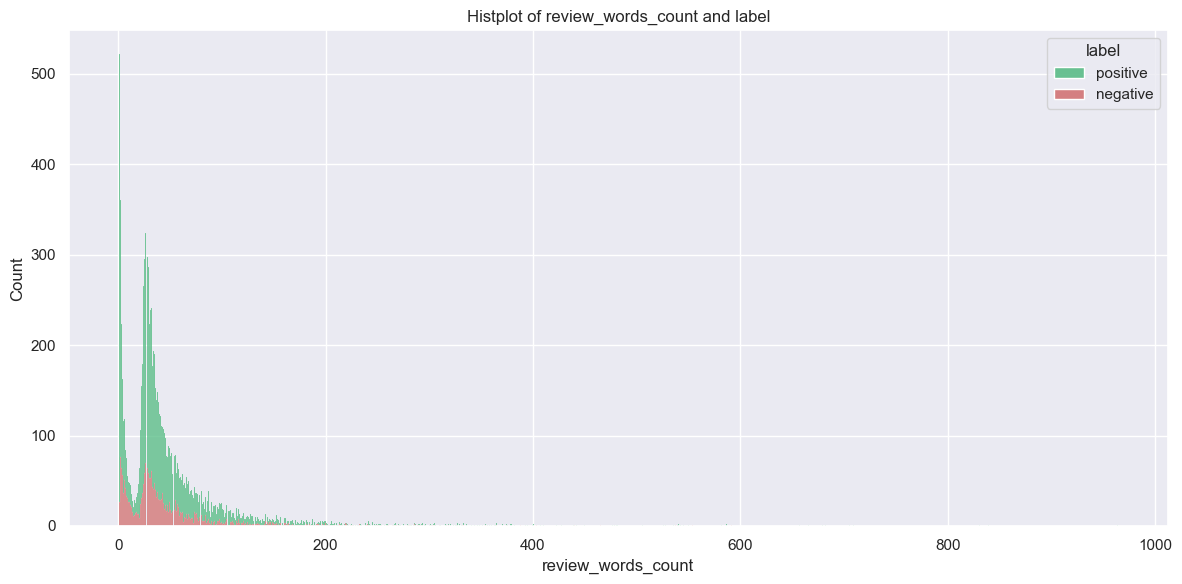

In [40]:
show_histplot(data, 'review_words_count', 'label')

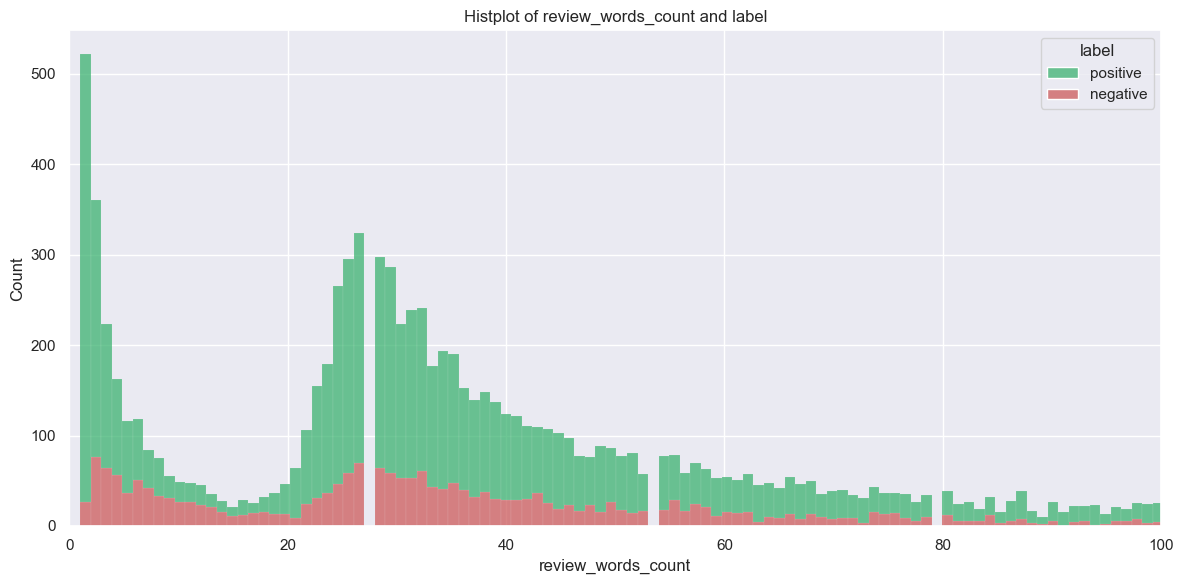

In [41]:
show_histplot(data, 'review_words_count', 'label', 0, 100)

In [42]:
most_popular_len = data['review_words_count'].value_counts().nlargest(10)
most_popular_len

1     522
2     361
27    324
28    298
26    295
29    286
25    265
32    241
31    239
3     223
Name: review_words_count, dtype: int64

Conclusions like above in letter section. 

### Longest and shortest reviews

In [43]:
data.sort_values(by='review_letter_count', )['review'].head(10)

8281    d
5280    .
8830    .
3743    o
9528    1
6274    .
1583    😄
4281    a
3736    4
8379    y
Name: review, dtype: object

In [44]:
data.loc[data['review'].str.len() < 3]['review'].head(10)

1577    ok
1583     😄
2090     D
2362    su
3576    gd
3583     5
3585    ok
3594    cc
3736     4
3743     o
Name: review, dtype: object

In [45]:
data.sort_values(by='review_words_count', ascending=False)['review'].head(10).unique()

array(['Hyderabadi Daawat as the name suggests has some authentic Hyderabadi food which you get to eat in the functions here in Hyderabad! Ever been to a Hyderabadi Daawat before? No not the hotel we\'re talking about a function, well if you\'ve been to one then You definitely know how much a Hyderabadi loves food and how much he spends on the Menu! And here at Hyderabadi Daawat, the restaurant, you get the same splendid variety of dishes to enjoy! The hotel is very easy to locate! Its on the main road...while coming from ORR or Gachibowli side it comes on the right side and if you\'re coming from Miyapur side then it will be on Your left! The restaurant has simple yet beautiful interiors, very calm and cozy place! They also have Banquet hall and a Conference hall and they also undertake Catering orders for parties and functions! And after the "DASTAR" was set we sat down for the food and they first brought the YAKHNI SHORBA! Shorba is nothing but the soup! Yakhni Shorba is a dish from

In [46]:
data.sort_values(by='review_words_count', ascending=False)['review'].head(1)

9622    Hyderabadi Daawat as the name suggests has som...
Name: review, dtype: object

### Review Preprocessing

In [47]:
data_raw['Review'].unique()

array(['The ambience was good, food was quite good . had Saturday lunch , which was cost effective .\nGood place for a sate brunch. One can also chill with friends and or parents.\nWaiter Soumen Das was really courteous and helpful.',
       'Ambience is too good for a pleasant evening. Service is very prompt. Food is good. Over all a good experience. Soumen Das - kudos to the service',
       'A must try.. great food great ambience. Thnx for the service by Pradeep and Subroto. My personal recommendation is Penne Alfredo Pasta:) ....... Also the music in the background is amazing.',
       ...,
       'Bad rating is mainly because of "Chicken Bone found in Veg food" and is not acceptable for a Vegetarian.\n\nTo satiate Cravings for chinese food we headed to Chinese Pavilion and there was also a voucher available in Little app for Luncheon tray for Rs 310 (Veg) [well do not bother for the voucher as the price for Veg Luncheon tray is Rs 275/- + taxes in the restaurant itself).\n\nThe am

In [48]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text) # remove adressses
    text = re.sub(r'www\.\S+', '', text) # remove adresses
    text = text.replace('.', ' ')
    text = text.replace('...', ' ')
    text = text.replace(',', ' ')
    text = re.sub(r'[^\w\s]', '', text) # remove punctuations and symbols
    text = re.sub('\w*\d\w*', '', text) # remove words with digits
    text = text.replace('  ', ' ')
    text = text.replace('   ', ' ')
    text = text.replace('\n', '')
    
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    tokens = word_tokenize(text)
    cleaned_tokens = []
    
    for tok in tokens:
        if tok not in stop_words:
            cleaned_tokens.append(stemmer.stem(tok))
    
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

In [49]:
data['review_cleaned'] = data['review'].apply(clean_text)

In [50]:
data.sample(5)

,restaurant,reviewer,review,rating,metadata,time,pictures,label,date,review_letter_count,review_words_count,review_cleaned
958,Cream Stone,Vinay,One of my Weekend chill out place!!\nMy favour...,5.0,5 Reviews,2018-12-24 00:13:00,0,positive,2018-12-24,130,17,one weekend chill placemi favourit ice cream a...
8260,Al Saba Restaurant,Shajahan M I,the delivery executive's behavior was very ver...,1.0,"1 Review , 1 Follower",2018-05-19 17:39:00,0,negative,2018-05-19,111,24,deliveri execut behavior bad dont ever send pe...
2836,Behrouz Biryani,Varma,Highly disappointed there is a sea of change i...,1.0,1 Review,2018-12-14 19:47:00,0,negative,2018-12-14,123,29,highli disappoint sea chang qualiti biryani or...
5737,Being Hungry,Vijay Pajjuru,good response from him delivered before the time,5.0,1 Review,2018-08-27 12:28:00,0,positive,2018-08-27,41,8,good respons deliv time
9831,Triptify,Kaushik Jagini,Always used to have a craving for chicken para...,4.0,"5 Reviews , 89 Followers",2018-11-11 08:11:00,0,positive,2018-11-11,318,74,alway use crave chicken paratha randomli look ...


In [51]:
data_raw['Review'].unique()[17]

"The best thing about this place is the food. My favorite go to dish here is definitely Alfredo Pasta although other items are good as well. And the service and behavior of the staff is top-notch. We we're attended by Mr. Soumen Das and he was extremely polite. Will definitely visit soon."

In [52]:
data['review_cleaned'].unique()[17]

'best thing place food favorit go dish definit alfredo pasta although item good well servic behavior staff topnotch attend mr soumen da extrem polit definit visit soon'

Review was cleaned of punctuation, emojis, numbers, etc. Then it was stemmed and tokenized. 

### Most common words and phrases

In [53]:
def create_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

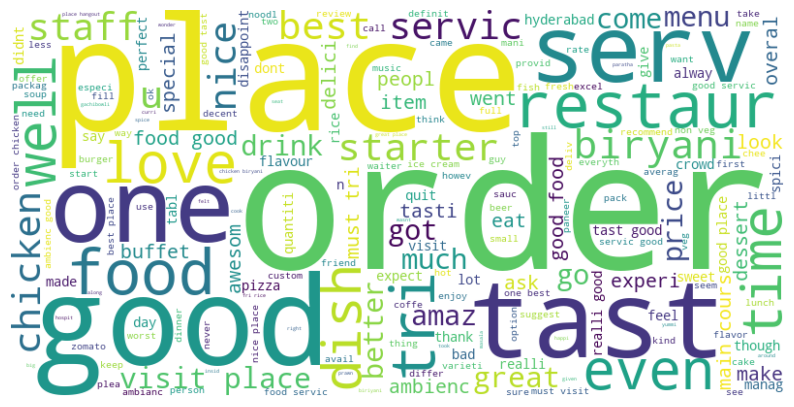

In [54]:
all_words = ' '.join(data['review_cleaned'])
create_word_cloud(all_words)

In [55]:
def create_common_words_df(data_ref, x):
    all_words = ' '.join(data_ref[x])
    
    common_words = {}
    all_words_splitted = all_words.split(' ')
    for w in all_words_splitted:
        if w in common_words.keys():
            common_words[w] += 1
        else:
            common_words[w] = 1
            
    df_common_words = pd.DataFrame.from_dict(common_words, orient='index', columns=['Value'])
    df_common_words.reset_index(inplace=True)
    df_common_words.columns = ['word', 'occurrences']
    
    return df_common_words

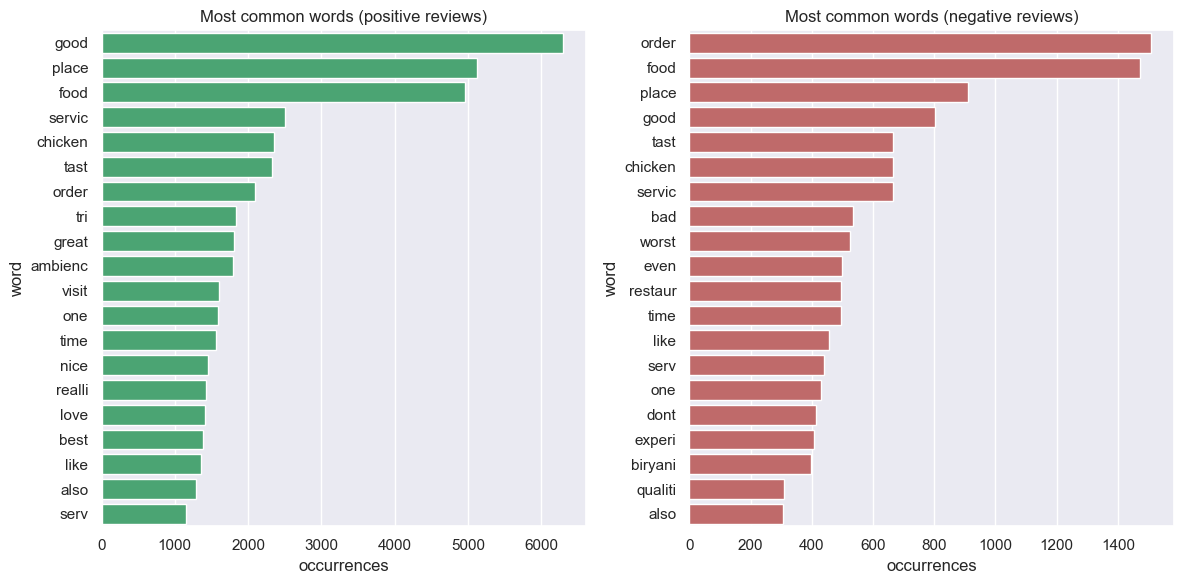

In [56]:
filtered = data.loc[data['label'] == 'positive']
df_most_common_words_positive = create_common_words_df(filtered, 'review_cleaned').sort_values(by='occurrences', ascending=False).head(20)

filtered = data.loc[data['label'] == 'negative']
df_most_common_words_negative = create_common_words_df(filtered, 'review_cleaned').sort_values(by='occurrences', ascending=False).head(20)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  

sns.barplot(y=df_most_common_words_positive['word'], x=df_most_common_words_positive['occurrences'], color='mediumseagreen', ax=ax1, orient='h')
ax1.set_title('Most common words (positive reviews)')

sns.barplot(y=df_most_common_words_negative['word'], x=df_most_common_words_negative['occurrences'], color='indianred', ax=ax2, orient='h')
ax2.set_title('Most common words (negative reviews)')

plt.tight_layout()
plt.show()

In [57]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

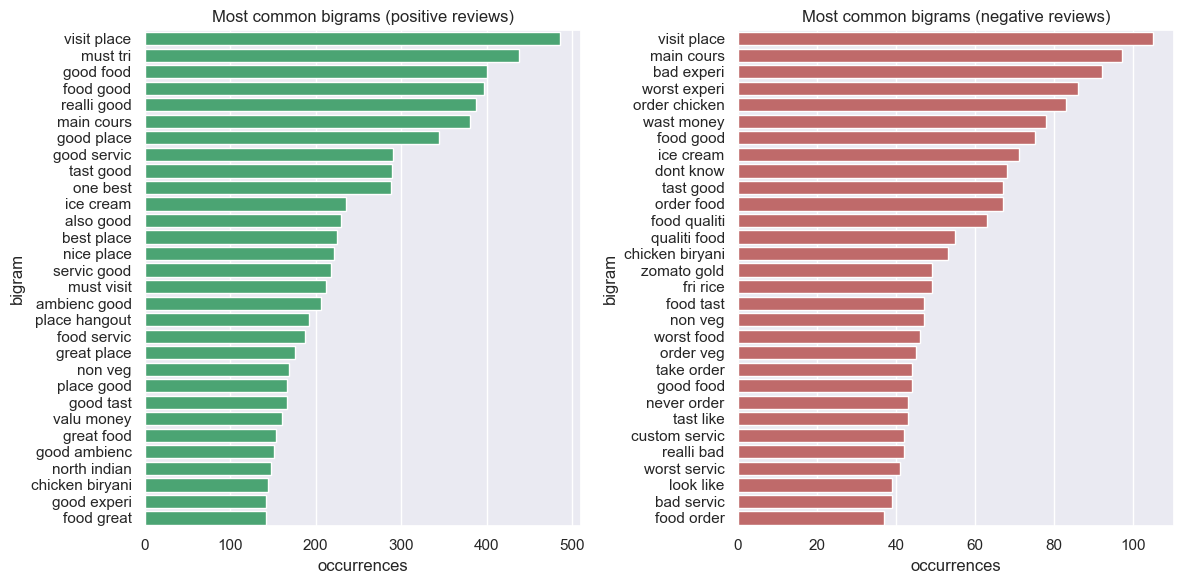

In [58]:
filtered = data.loc[data['label'] == 'positive']
df_bigrams_positive = pd.DataFrame(get_top_n_bigram(filtered['review_cleaned'], 30), columns=['bigram', 'occurrences'])

filtered = data.loc[data['label'] == 'negative']
df_bigrams_negative = pd.DataFrame(get_top_n_bigram(filtered['review_cleaned'], 30), columns=['bigram', 'occurrences'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  

sns.barplot(y=df_bigrams_positive['bigram'], x=df_bigrams_positive['occurrences'], color='mediumseagreen', ax=ax1, orient='h')
ax1.set_title('Most common bigrams (positive reviews)')

sns.barplot(y=df_bigrams_negative['bigram'], x=df_bigrams_negative['occurrences'], color='indianred', ax=ax2, orient='h')
ax2.set_title('Most common bigrams (negative reviews)')

plt.tight_layout()
plt.show()

In [59]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

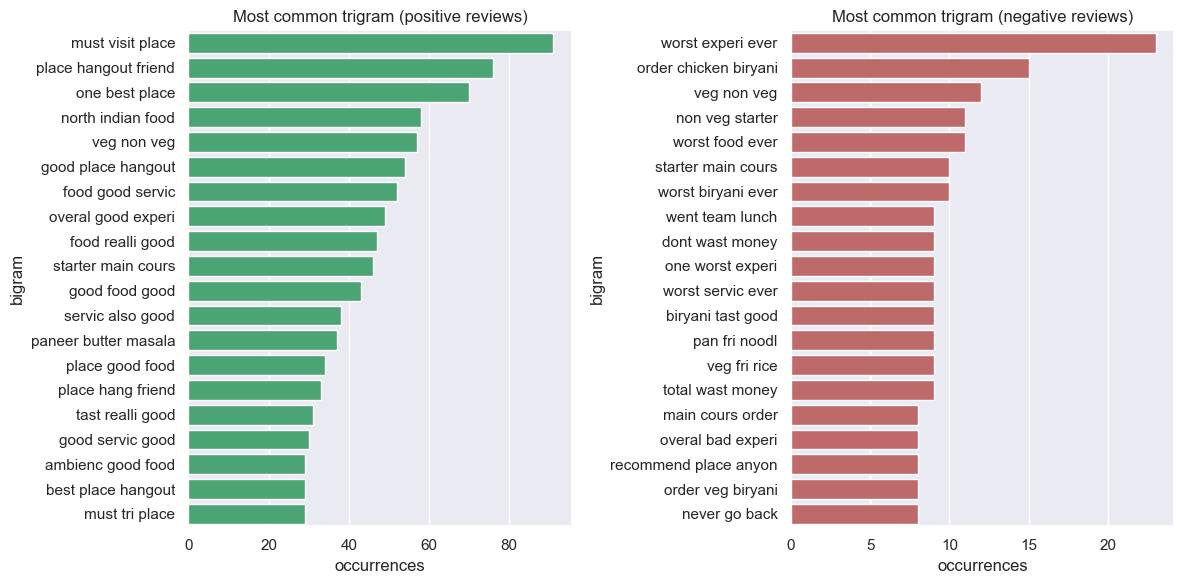

In [60]:
filtered = data.loc[data['label'] == 'positive']
df_bigrams_positive = pd.DataFrame(get_top_n_trigram(filtered['review_cleaned'], 20), columns=['bigram', 'occurrences'])

filtered = data.loc[data['label'] == 'negative']
df_bigrams_negative = pd.DataFrame(get_top_n_trigram(filtered['review_cleaned'], 20), columns=['bigram', 'occurrences'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  

sns.barplot(y=df_bigrams_positive['bigram'], x=df_bigrams_positive['occurrences'], color='mediumseagreen', ax=ax1, orient='h')
ax1.set_title('Most common trigram (positive reviews)')

sns.barplot(y=df_bigrams_negative['bigram'], x=df_bigrams_negative['occurrences'], color='indianred', ax=ax2, orient='h')
ax2.set_title('Most common trigram (negative reviews)')

plt.tight_layout()
plt.show()

In [61]:
def get_percent_of_occurances(word, df_ref):
    df_ref_count = df_ref.shape[0]
    occurances = df_ref[df_ref['word'] == word].iloc[0]['occurrences']
    return round(occurances / df_ref_count, 3) * 100

In [62]:
common_words_df = create_common_words_df(data, 'review_cleaned')

words = [
    'chicken',
    'food',
    'servic',
    'ambienc',
    'friend',
    'masala',
    'veg',
    'ice'
]

for w in words:
    print(f"{w} occurances: {get_percent_of_occurances(w, common_words_df)}%")

chicken occurances: 22.2%
food occurances: 47.3%
servic occurances: 23.3%
ambienc occurances: 14.499999999999998%
friend occurances: 6.4%
masala occurances: 2.3%
veg occurances: 8.200000000000001%
ice occurances: 3.1%


- Clients most often write about food taste.
- But service is also high in the rank. 
- Negative reviews often contain bad opinion about lack of vegan option. 
- Many clients pay attention to biryani chicken and ice cream (but chicken more). Negative reviews often contain bad opinion about these dishes. 
- In positive reviews clients often praise the place as a good place for hangout with friends.
- Paneer butter masala and North Indian Food often in good reviews. 
- Saying 'good place' clients mean visual values of the restaurant, good positioning in the city or overall good experience?

### Word count by Label 

In [63]:
word_count_label_median = data.groupby(by='label', as_index=False).median()
word_count_label_median

,label,rating,pictures,review_letter_count,review_words_count
0,negative,1.0,0.0,155.0,34.0
1,positive,5.0,0.0,157.0,34.0


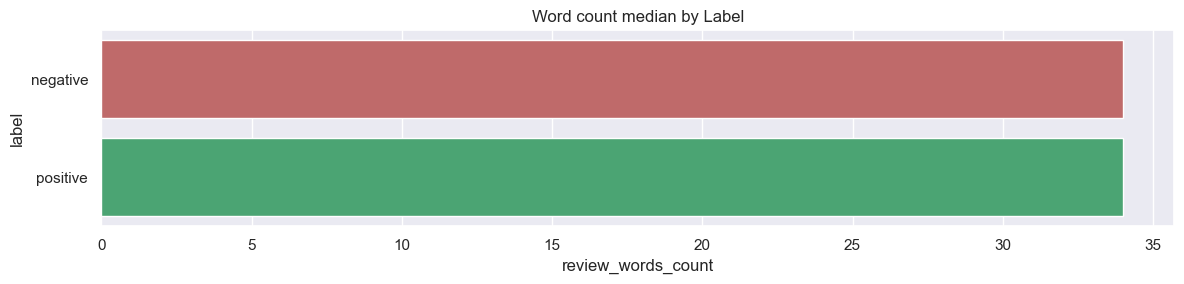

In [64]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 3))  

sns.barplot(y=word_count_label_median['label'], x=word_count_label_median['review_words_count'], palette=custom_palette, ax=ax1, orient='h')
ax1.set_title('Word count median by Label')

plt.tight_layout()
plt.show()

### Restaurant and Reviewer

Name of the reviewed restaurant and name/nickname of the reviewer.

In [65]:
data['restaurant'].value_counts()

Beyond Flavours                          100
KS Bakers                                100
The Indi Grill                           100
The Tilt Bar Republic                    100
Yum Yum Tree - The Arabian Food Court    100
                                        ... 
The Old Madras Baking Company             99
Amul                                      99
Hyderabad Chefs                           98
Arena Eleven                              85
American Wild Wings                       77
Name: restaurant, Length: 100, dtype: int64

In [66]:
data['reviewer'].value_counts().nlargest(20)

Ankita                            13
Parijat Ray                       13
Kiran                             12
Jay Mehta                         11
Vedant Killa                      11
Sravani                           10
Priyanka                          10
Siva Kumar                        10
Age Of Foodies (Suraj Karambe)    10
Manojkumar D Nambisan             10
Vinay                              9
Khushboo Pandey                    9
Prasun Gokhlani                    9
Nillu                              9
Kumar                              9
Prachita Jayaswal                  9
Anusha Sinha                       9
Avin Seth                          8
The Foodie Bookworm                8
Aman Agarwal                       8
Name: reviewer, dtype: int64

The number of reviews is almost the same for each restaurant.

### Pictures

Number of images given with the opinion. 

In [67]:
data.groupby(by='label')['pictures'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
negative,2447.0,0.177360,1.020042,0.0,0.0,0.0,0.0,34.0
positive,7507.0,0.939257,2.883757,0.0,0.0,0.0,0.0,64.0


In [68]:
data['pictures'].value_counts().head(10)

0    7971
1     706
2     383
3     246
4     129
5     116
7      86
6      85
8      55
9      47
Name: pictures, dtype: int64

In [69]:
def create_picture_bin(pictures):
    if pictures > 2:
        return '> 2'
    return str(pictures)

In [70]:
data['pictures_bin'] = data['pictures'].apply(create_picture_bin)

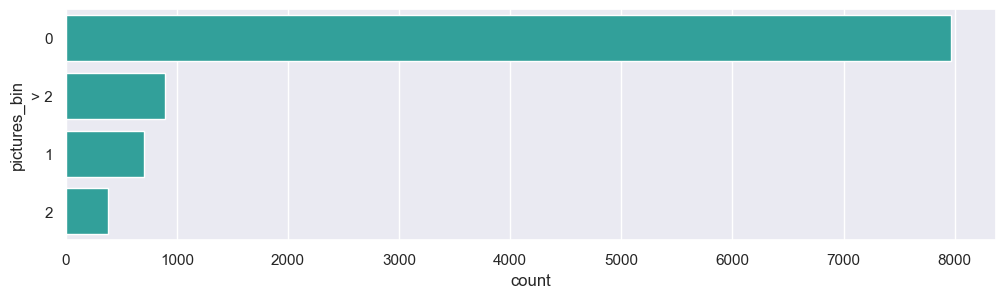

In [71]:
fig, ax = plt.subplots(figsize=(12, 3))
sns.countplot(data=data, y='pictures_bin', orient='h', color='lightseagreen')
plt.show()

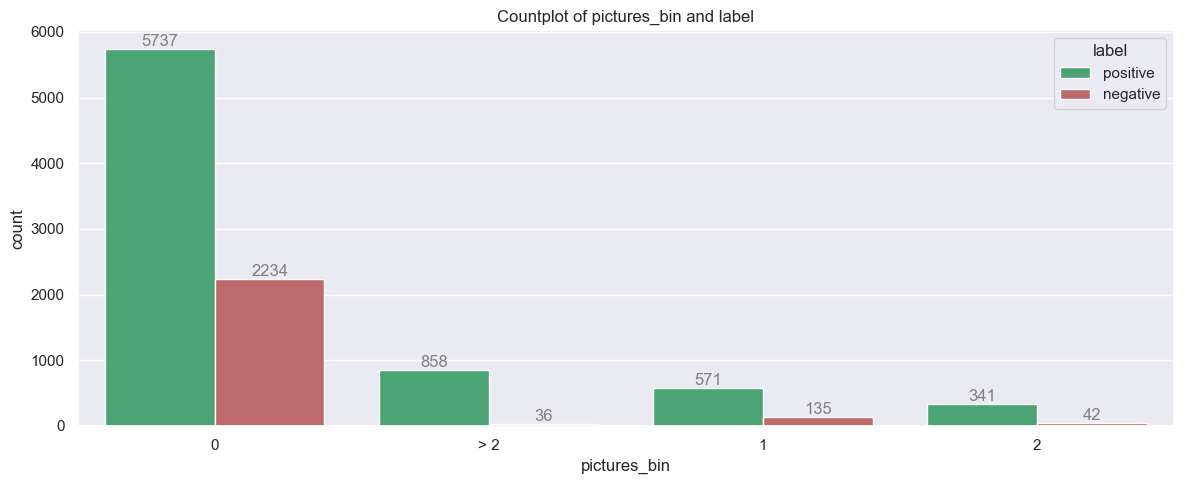

In [72]:
show_category_countplot(data, 'pictures_bin', 'label')

The more pictures, the fewer neutral and negative opinions.

## Training Models

In [73]:
def print_confusion_matrix_heatmap(conf_mat, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greys', 
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [74]:
def print_metrics(y_test_ref, y_pred_ref):
    accuracy = accuracy_score(y_test_ref, y_pred_ref)
    precision = precision_score(y_test_ref, y_pred_ref)
    recall = recall_score(y_test_ref, y_pred_ref)
    f1 = f1_score(y_test_ref, y_pred_ref)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)
    return accuracy, precision, recall, f1

In [75]:
columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1']
score_df = pd.DataFrame(columns=columns)

In [76]:
data_copy = data.copy()
data_copy = data_copy.sample(frac=1.0, random_state=42)

x = data_copy['review_cleaned']
x_uncleaned = data_copy['review']
y = data_copy['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_uncleaned_train, x_uncleaned_test, y_train, y_test = train_test_split(x_uncleaned, y, test_size=0.2, random_state=42)

In [77]:
tfid = TfidfVectorizer()
x_train_tfid = tfid.fit_transform(x_train)
x_test_tfid = tfid.transform(x_test)

In [78]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

In [79]:
pickle.dump(tfid, open('tfidf.pkl', 'wb'))

### Speed training for basic models

In [80]:
models = {
    'KNeighborsClassifier' : neighbors.KNeighborsClassifier(),
    'DecisionTreeClassifier' : tree.DecisionTreeClassifier(),
    'RandomForestClassifier' : ensemble.RandomForestClassifier(),
    'SVC' : svm.SVC(),
    'LogisticRegression' : LogisticRegression(max_iter=1000)
}

In [81]:
accuracy = []
m_keys = list(models.keys())
m_values = list(models.values())

for i in range(0, len(models)):
    print(f'Training {m_keys[i]}...')
    cross_val = cross_val_score(m_values[i], x_train_tfid, y_train, scoring='accuracy', cv=StratifiedKFold(3)).mean()
    accuracy.append(cross_val)

Training KNeighborsClassifier...
Training DecisionTreeClassifier...
Training RandomForestClassifier...
Training SVC...
Training LogisticRegression...


In [82]:
quick_score_df = pd.DataFrame({'Model': m_keys, 'Accuracy': accuracy})
quick_score_df

,Model,Accuracy
0,KNeighborsClassifier,0.753483
1,DecisionTreeClassifier,0.842395
2,RandomForestClassifier,0.888358
3,SVC,0.900288
4,LogisticRegression,0.895140


### CNN

In [83]:
y_train_dummies = pd.get_dummies(y_train).values
y_test_dummies = pd.get_dummies(y_test).values

max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

total_word = len(tokenizer.word_index)
print(f'Total distinct words: {total_word}')

max_input_len = 100
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)
x_train_padded = pad_sequences(train_sequences, maxlen=max_input_len, padding='post')
x_test_padded = pad_sequences(test_sequences, maxlen=max_input_len, padding='post')

Total distinct words: 11967


In [84]:
embedding_dim = 100  # Dimension of word embeddings
num_filters = 128  # Number of filters in convolutional layer
kernel_size = 3  # Size of convolutional filters
labels_num = 2 # Number of labels

batch_size = 64
epochs = 5

In [85]:
from keras import backend as K

def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return K.mean(f1)

In [86]:
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_input_len))
cnn_model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(32, activation='linear'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(labels_num, activation='softmax'))

metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_score]

cnn_model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=metrics)

In [87]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = cnn_model.fit(x_train_padded, y_train_dummies, batch_size=batch_size, epochs=epochs, validation_data=(x_test_padded, y_test_dummies))

Epoch 1/5
125/125 [==============================] - 9s 15ms/step - loss: 0.4060 - accuracy: 0.8188 - precision: 0.8188 - recall: 0.8188 - f1_score: 0.6465 - val_loss: 0.2545 - val_accuracy: 0.8940 - val_precision: 0.8940 - val_recall: 0.8940 - val_f1_score: 0.8528
Epoch 2/5
125/125 [==============================] - 1s 11ms/step - loss: 0.2104 - accuracy: 0.9199 - precision: 0.9199 - recall: 0.9199 - f1_score: 0.8889 - val_loss: 0.2320 - val_accuracy: 0.9036 - val_precision: 0.9036 - val_recall: 0.9036 - val_f1_score: 0.8645
Epoch 3/5
125/125 [==============================] - 1s 11ms/step - loss: 0.1417 - accuracy: 0.9501 - precision: 0.9501 - recall: 0.9501 - f1_score: 0.9294 - val_loss: 0.2476 - val_accuracy: 0.9001 - val_precision: 0.9001 - val_recall: 0.9001 - val_f1_score: 0.8606
Epoch 4/5
125/125 [==============================] - 1s 11ms/step - loss: 0.0896 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9711 - f1_score: 0.9598 - val_loss: 0.2978 - val_accuracy: 0.8885 - va

63/63 [==============================] - 0s 5ms/step - loss: 0.3220 - accuracy: 0.8980 - precision: 0.8980 - recall: 0.8980 - f1_score: 0.8487
Test Loss: 0.3219743072986603, Test Accuracy: 0.8980411887168884
63/63 [==============================] - 0s 1ms/step


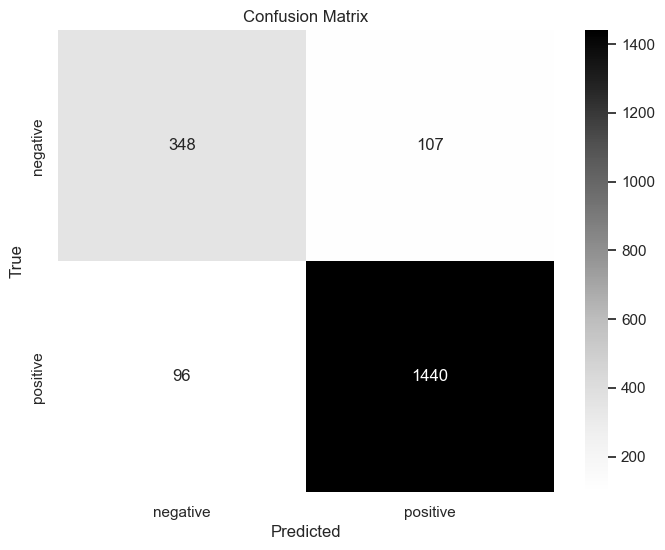

In [88]:
loss, accuracy, precision, recall, f1 = cnn_model.evaluate(x_test_padded, y_test_dummies)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

score_df.loc[len(score_df)] = ['CNN', accuracy, precision, recall, f1]

y_pred = np.argmax(cnn_model.predict(x_test_padded), axis=1)
conf_mat = confusion_matrix(np.argmax(y_test_dummies, axis=1), y_pred)
print_confusion_matrix_heatmap(conf_mat, ['negative', 'positive'])

<AxesSubplot:>

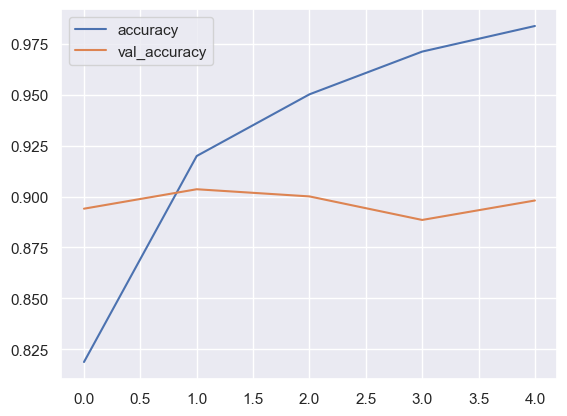

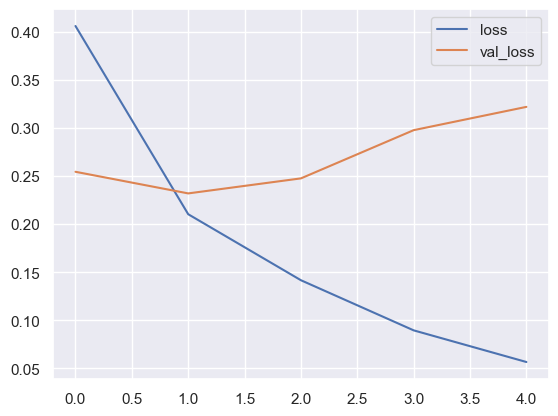

In [89]:
metrics = pd.DataFrame(history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

### LSTM

In [90]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_input_len))
lstm_model.add(Bidirectional(LSTM(16)))
lstm_model.add(Dense(32, activation='linear'),)
# model.add(Dropout(0.5))
lstm_model.add(Dense(labels_num, activation='softmax'))

metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_score]

lstm_model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=metrics)

In [91]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = lstm_model.fit(x_train_padded, y_train_dummies, batch_size=batch_size, epochs=epochs, validation_data=(x_test_padded, y_test_dummies))

Epoch 1/5
125/125 [==============================] - 10s 39ms/step - loss: 0.3612 - accuracy: 0.8409 - precision_1: 0.8409 - recall_1: 0.8409 - f1_score: 0.7020 - val_loss: 0.2476 - val_accuracy: 0.8980 - val_precision_1: 0.8980 - val_recall_1: 0.8980 - val_f1_score: 0.8537
Epoch 2/5
125/125 [==============================] - 4s 29ms/step - loss: 0.1877 - accuracy: 0.9243 - precision_1: 0.9243 - recall_1: 0.9243 - f1_score: 0.8951 - val_loss: 0.2633 - val_accuracy: 0.8960 - val_precision_1: 0.8960 - val_recall_1: 0.8960 - val_f1_score: 0.8423
Epoch 3/5
125/125 [==============================] - 4s 29ms/step - loss: 0.1408 - accuracy: 0.9463 - precision_1: 0.9463 - recall_1: 0.9463 - f1_score: 0.9262 - val_loss: 0.2987 - val_accuracy: 0.9041 - val_precision_1: 0.9041 - val_recall_1: 0.9041 - val_f1_score: 0.8569
Epoch 4/5
125/125 [==============================] - 4s 29ms/step - loss: 0.1095 - accuracy: 0.9574 - precision_1: 0.9574 - recall_1: 0.9574 - f1_score: 0.9416 - val_loss: 0.307

63/63 [==============================] - 1s 11ms/step - loss: 0.3714 - accuracy: 0.8945 - precision_1: 0.8945 - recall_1: 0.8945 - f1_score: 0.8427
Test Loss: 0.37140849232673645, Test Accuracy: 0.8945253491401672
63/63 [==============================] - 1s 8ms/step


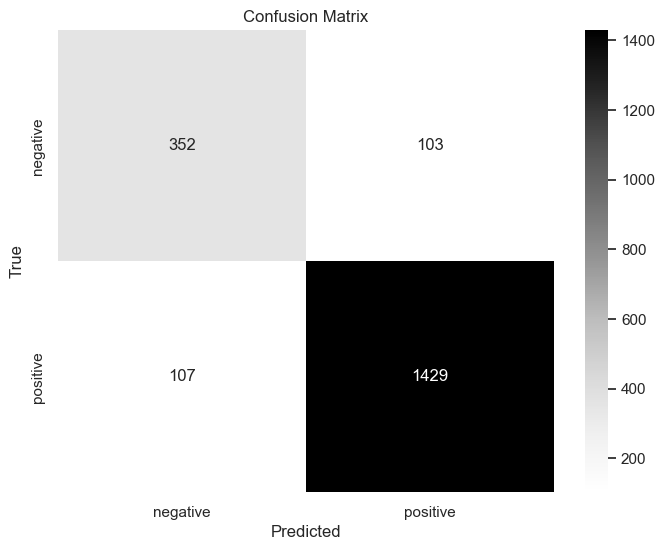

In [92]:
loss, accuracy, precision, recall, f1 = lstm_model.evaluate(x_test_padded, y_test_dummies)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

score_df.loc[len(score_df)] = ['LSTM', accuracy, precision, recall, f1]

y_pred = np.argmax(lstm_model.predict(x_test_padded), axis=1)
conf_mat = confusion_matrix(np.argmax(y_test_dummies, axis=1), y_pred)
print_confusion_matrix_heatmap(conf_mat, ['negative', 'positive'])

<AxesSubplot:>

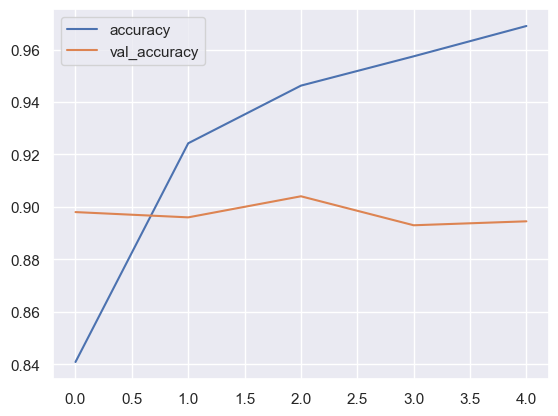

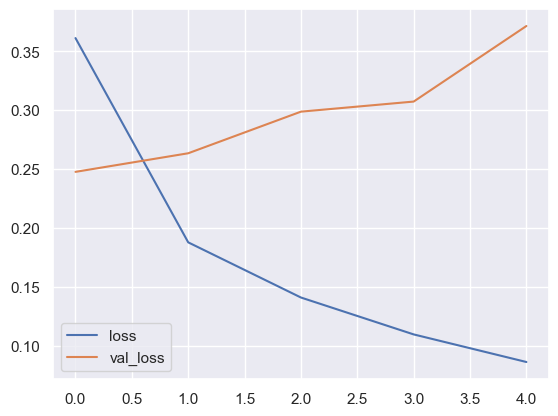

In [93]:
metrics = pd.DataFrame(history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

### Pretrained BERT

In [94]:
question_pipeline = transformers.pipeline("question-answering")

No model was supplied, defaulted to distilbert-base-cased-distilled-squad (https://huggingface.co/distilbert-base-cased-distilled-squad)


In [95]:
context = x_uncleaned_train[0]
context

'The ambience was good, food was quite good . had Saturday lunch , which was cost effective .\nGood place for a sate brunch. One can also chill with friends and or parents.\nWaiter Soumen Das was really courteous and helpful.'

In [96]:
result = question_pipeline(question='What was the ambience like?', context=context)
result

{'score': 0.9027485847473145, 'start': 17, 'end': 21, 'answer': 'good'}

In [97]:
result = question_pipeline(question='What was the atmosphere like?', context=context)
result

{'score': 0.35360604524612427, 'start': 0, 'end': 12, 'answer': 'The ambience'}

In [98]:
result = question_pipeline(question='What was the food like?', context=context)
result

{'score': 0.37097078561782837, 'start': 0, 'end': 12, 'answer': 'The ambience'}

In [99]:
bert_sentiment_pipeline = transformers.pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
x_test_limited = x_uncleaned_test[:200]
y_test_limited = y_test[:200]
y_pred = []

for rev in x_test_limited.values:
    pred = bert_sentiment_pipeline(rev)
    y_pred.append(pred[0]['label'].lower())
    
y_test_limited_encoded = le.fit_transform(y_test_limited)
y_pred_encoded = le.fit_transform(y_pred)

In [ ]:
accuracy, precision, recall, f1 = print_metrics(y_test_limited_encoded, y_pred_encoded)

score_df.loc[len(score_df)] = ['Pretrained BERT', accuracy, precision, recall, f1]

conf_matrix = confusion_matrix(y_test_limited_encoded, y_pred_encoded)
print_confusion_matrix_heatmap(conf_matrix, le.classes_)

### Training BERT

In [ ]:
class Config():
    seed_val = 17
    device = 'gpu'
    epochs = 3
    batch_size = 6
    seq_length = 512
    max_len=192
    lr = 2e-5
    eps = 1e-8
    pretrained_model = 'distilbert-base-uncased'
    test_size=0.1
    random_state=42
    add_special_tokens=True 
    return_attention_mask=True 
    pad_to_max_length=True 
    do_lower_case=False
    return_tensors='pt'
    auto = tf.data.experimental.AUTOTUNE

config = Config()

In [ ]:
data['label_encoded'] = data['label'].apply(create_label_encoded)

In [ ]:
data_sampled = data.sample(100)
train_data, test_data = train_test_split(data_sampled, test_size=config.test_size, random_state=config.random_state, stratify=data_sampled.label.values)

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained(config.pretrained_model, do_lower_case=config.do_lower_case)

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
tokenizer.save_pretrained('.')

fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

In [ ]:
x_train = fast_encode(train_data.review_cleaned.astype(str), fast_tokenizer, maxlen=config.max_len)
x_test = fast_encode(test_data.review_cleaned.astype(str), fast_tokenizer, maxlen=config.max_len)

y_train = train_data.label_encoded
y_test = test_data.label_encoded

In [ ]:
print(f'x_train.shape: {x_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'x_test.shape: {x_test.shape}')
print(f'y_test.shape: {y_test.shape}')

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(config.batch_size)
    .prefetch(config.auto)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(config.batch_size)
)

In [ ]:
def build_model(transformer, max_len=512):
    input_word_ids = keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = keras.layers.Dense(1, activation='sigmoid')(cls_token)
    
    model = keras.models.Model(inputs=input_word_ids, outputs=out)
    model.compile(keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
%%time
strategy = tf.distribute.get_strategy()
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained(config.pretrained_model)
    )
    model = build_model(transformer_layer, max_len=config.max_len)
model.summary()

In [ ]:
n_steps = x_train.shape[0]
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=test_dataset,
    batch_size=config.batch_size,
    epochs=config.epochs
)

### Boosting SVC

In [ ]:
model = svm.SVC(gamma='scale', kernel='rbf', C=1)
model.fit(x_train_tfid, y_train_encoded)

y_pred_origin = model.predict(x_test_tfid)

y_scores = model.decision_function(x_test_tfid)
threshold = 0.3
y_pred = (y_scores > threshold).astype(int)

accuracy, precision, recall, f1 = print_metrics(y_test_encoded, y_pred)
score_df.loc[len(score_df)] = ['SVC', accuracy, precision, recall, f1]

conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print_confusion_matrix_heatmap(conf_matrix, le.classes_)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_scores)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
print(f'Before adding threshold: {roc_auc_score(y_test_encoded, y_pred_origin)}')
print(f'After adding threshold: {roc_auc_score(y_test_encoded, y_pred)}') 

### Models comparision and custom tests

In [ ]:
score_df

In [ ]:
def predict_using_BERT(review_text):
    return bert_sentiment_pipeline(review_text)[0]['label'].lower()

In [ ]:
def predict_using_svc(review_text):
    review_text_cleaned = clean_text(review_text)
    tfid_matrix = tfid.transform([review_text_cleaned])
    pred = model.predict(tfid_matrix)[0]
    
    return le.classes_[pred]

In [ ]:
def predict_using_lstm(review_text):
    review_text_cleaned = clean_text(review_text)

    seq = tokenizer.texts_to_sequences(review_text_cleaned)
    padded = pad_sequences(seq, maxlen=max_input_len, padding='post')

    pred = lstm_model.predict(padded)
    predicted_label_index = np.argmax(pred)
    result = le.inverse_transform([predicted_label_index])[0]
    
    return result

In [ ]:
def predict_using_cnn(review_text):
    review_text_cleaned = clean_text(review_text)
    
    seq = tokenizer.texts_to_sequences(review_text_cleaned)
    padded = pad_sequences(seq, maxlen=max_input_len, padding='post')
    
    pred = cnn_model.predict(padded)
    predicted_label_index = np.argmax(pred)

    result = le.inverse_transform([predicted_label_index])[0]
    
    return result

In [ ]:
text = [
    "Good restaurant, very good!",
    "The restaurant is ugly and stinks.",
    "The restaurant is bad.",
    "Oh, God. This was terrible.",
    'I love it!',
    "I am not sure. Not good, not bad.",
    'I did not like the food.',
    'Food had bad taste.',
    'This restaurant is good. But other restaurants are bad.',
    'Not good restaurant',
    'Not so good restaurant',
    'Is not good',
]

for t in text:
    print(f'{t}\nSVM : ({predict_using_svc(t)})\nBERT: ({predict_using_BERT(t)})\n')

## Summary
In the conclusions below, I assumed that "positive" reviews will be assiged to rating higher than or equal to 3, and "negative" reviews to lower than that. And this is because machine learning algorithms performed best at these intervals.
 
### Interesting facts
1. There are more positive opinions than negative ones. **75%** reviews was bigger or equal to rating 3.
2. Usually users used **24 to 57** words for review. The longest one had **9622** words.
3. In positive opinions the word **"good"** was the most popular, on the second place was **"place"** and on the third **"food"**
4. In negative opinions the word **"order"** was the most popular, on the second place was **"food"** and on the third **"place"**. Here the word "good" was fourth. 
5. There are huge number of reviews containing less than 5 words. Then there is significantly drop, and huge increase around 23 words.

### What makes restaurant good?
1. Food taste. No surprise. Vast majority of reviews contained opinion about food taste and way of serving. 
2. Chicken. About a **22%** of reviews mentioned about chicken, especially biryani chicken. It is important for the restaurant owner to has good taste chicken in the menu.
3. Ambience. In positive reviews a lot of clients wrote about good ambience and were refering to the restaurant as a hangout. The restaurant owner should remember not only about food, but also about visuals and service. **23.3%** of opinions contained service-like words and **14.5%** ambienc-like. 
4. Veg option. Negative opinions often contained lack of vegetarian option. The owner should considere supplementing the menu with it. More than **8%** of opinions contained veg-like words.

### Classification model
- For now it has accuracy of 90% (SVM and CNN) and 2 output labels. I also trained it with 3 labels (with "neutral"), but then metrics had slighly lower values (85% accuracy of CNN). 
- Model often makes errors in phrases where subject matters, ex. "This restaurant is good. But other restaurants are bad." is signed as negative. 
- Moreover, phrases like "Is not good." have positive prediction so there is a problem with denial detection. 
- In my opinion, one approach to boost the scores could be data augmentation for such phrases like above. Maybe use of some already trained language model to create similar phrases?